**IMDB 電影評論情緒分析**
===

大家早安午安晚安，我是YI-HONG，這篇Notebook包含我對IMDB的評論做出的情緒分析

## 資料簡介

這份IMDB的影評資料來自standford大學在2011年發表的文章「[Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)」，作為自然語言處理(NLP)的常見資料集，可從直接從library datasets取得資料。


資料包含2個部分：

1. text：影評
2. label：影評情緒，0代表負面，1代表正面。


## 資料處理

載入所需的library

In [2]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import transformers
import pandas as pd
import seaborn as sns

In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

載入資料

In [4]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
print(train_data.shape)
print(test_data.shape)

(25000, 2)
(25000, 2)


訓練以及測試集都各有25000筆，接著畫出影評長度的分布

In [6]:
merged_dataset = datasets.concatenate_datasets([train_data,test_data])

def get_text_length(example):
    return {'text_length': len(example['text'].split())}

# 使用 map 方法處理整個資料集，並將結果儲存在一個新欄位中
dataset_with_length = merged_dataset.map(get_text_length)

text_lengths = pd.Series(dataset_with_length['text_length'])


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

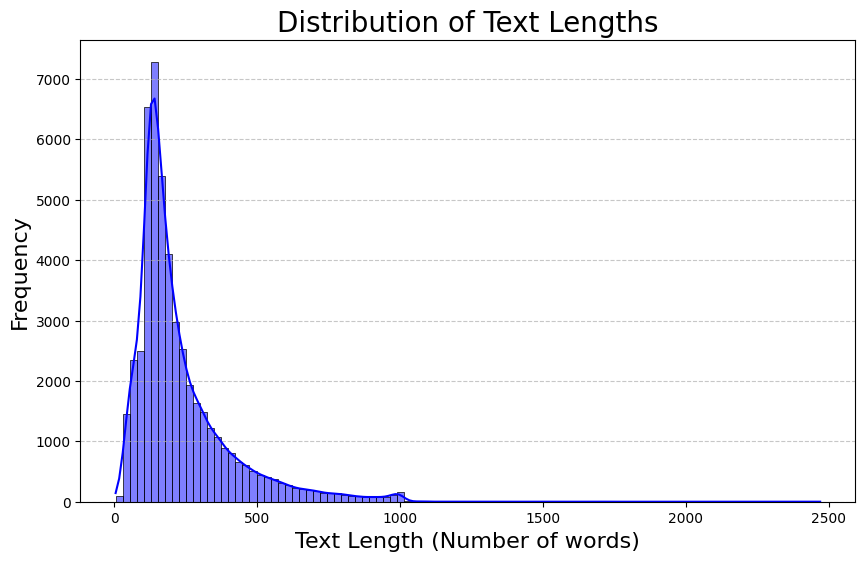

In [7]:

plt.figure(figsize=(10, 6))

sns.histplot(
    text_lengths,
    bins=100,
    kde=True,
    color='blue'
)

plt.title('Distribution of Text Lengths', fontsize=20)
plt.xlabel('Text Length (Number of words)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

可以看到影評長度集中在200字上下。接著對字進行編碼，以便建立模型

In [8]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize("hi! how are you?")

['hi', '!', 'how', 'are', 'you', '?']

In [ ]:
tokenizer.encode("hi! how are you?")

[101, 7632, 999, 2129, 2024, 2017, 1029, 102]

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("hi! how are you?"))

['[CLS]', 'hi', '!', 'how', 'are', 'you', '?', '[SEP]']

In [ ]:
tokenizer("hi! how are you?")

{'input_ids': [101, 7632, 999, 2129, 2024, 2017, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

將影評如同上述的例句編碼成模型可接收的數值，並處理訓練集以及測試集。

In [ ]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
pad_index = tokenizer.pad_token_id

在訓練集當中再分出25%的資料當作驗證集

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## 模型建立

在此使用的是transfromer模型：

**核心思想：**

Transformer最核心的創新是注意力機制，它允許模型在處理一個詞時，同時考慮到輸入序列中所有其他詞的重要性。模型會為每個詞分配一個「注意力分數」，這個分數代表了其他詞對當前詞的影響力。這使得模型能夠同時處理整個序列，不僅大幅提升了訓練速度，還能更有效地捕捉句子中的長距離依賴關係。

**架構組成：**

編碼器（Encoder）：負責接收輸入序列（例如：一個句子），並將其轉換成一個高維度的數值表示，捕捉語義資訊。編碼器由多個相同的層堆疊而成。

解碼器（Decoder）：負責根據編碼器的輸出，生成另一個序列（例如：翻譯後的句子）。解碼器同樣由多個相同的層堆疊而成。

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
transformer = transformers.AutoModel.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

確定模型在GPU上訓練

In [ ]:
output_dim = train_data.features["label"].num_classes
freeze = False

model = Transformer(transformer, output_dim, freeze)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.to(device)


檢查模型參數數量

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 109,483,778 trainable parameters


選擇Adam作為optimizer並且learning rate = 0.00001




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    predictions = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)

            predicted_class = torch.argmax(prediction, dim=1)
            predictions.extend(predicted_class.tolist())

            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs), predictions

開始訓練模型，由於模型較為巨大，因此我們不會訓練太多epochs

In [ ]:
n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   0%|          | 0/2344 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
evaluating...: 100%|██████████| 782/782 [03:38<00:00,  3.57it/s]


epoch: 0
train_loss: 0.253, train_acc: 0.894
valid_loss: 0.197, valid_acc: 0.927


evaluating...: 100%|██████████| 782/782 [03:39<00:00,  3.56it/s]


epoch: 1
train_loss: 0.135, train_acc: 0.951
valid_loss: 0.203, valid_acc: 0.927


evaluating...: 100%|██████████| 782/782 [03:38<00:00,  3.57it/s]

epoch: 2
train_loss: 0.069, train_acc: 0.978
valid_loss: 0.237, valid_acc: 0.930


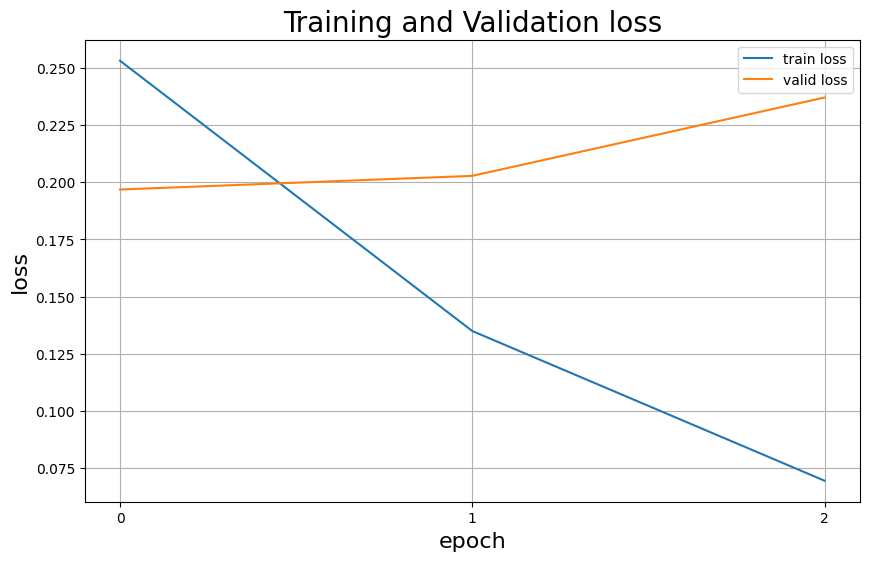

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_title("Training and Validation loss", fontsize=20)
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("loss", fontsize=16)
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

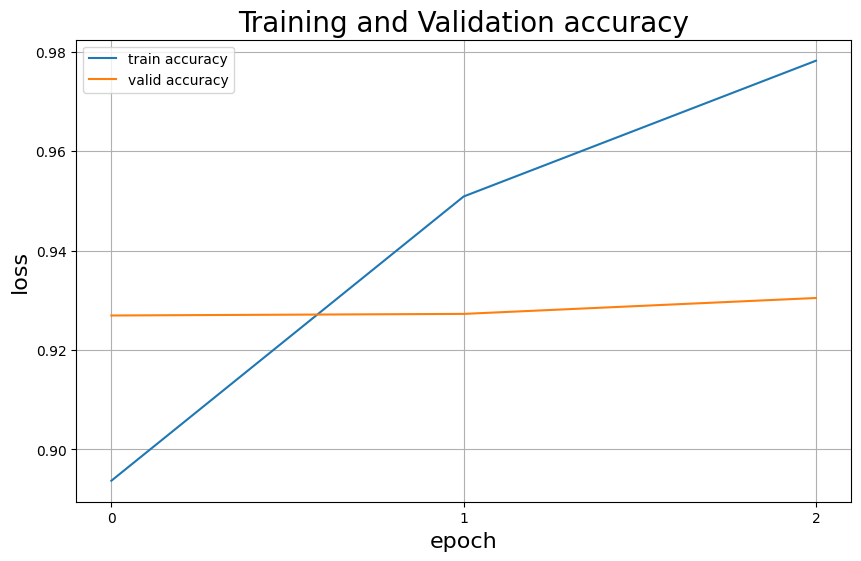

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_title("Training and Validation accuracy", fontsize=20)
ax.set_xlabel("epoch", fontsize=16)
ax.set_ylabel("loss", fontsize=16)
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

因為epoch數目較少，較難從上述2張圖當中分辨出模型是否訓練得當，但觀察訓練過程中的loss以及accuracy表現良好，因此我們評估模型結果。

## 模型預測

In [ ]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc, predicted_label = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 3125/3125 [13:50<00:00,  3.76it/s]


模型準確率為93%，預測表現良好，我認為雖然epoch數目較少，但鑒於BERT是強大的模型，透過少許的epoch便能學到夠多資訊做出正確決斷。

In [ ]:
print(f"test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}")

test_loss: 0.1874, test_acc: 0.9307


畫出confusion matrix

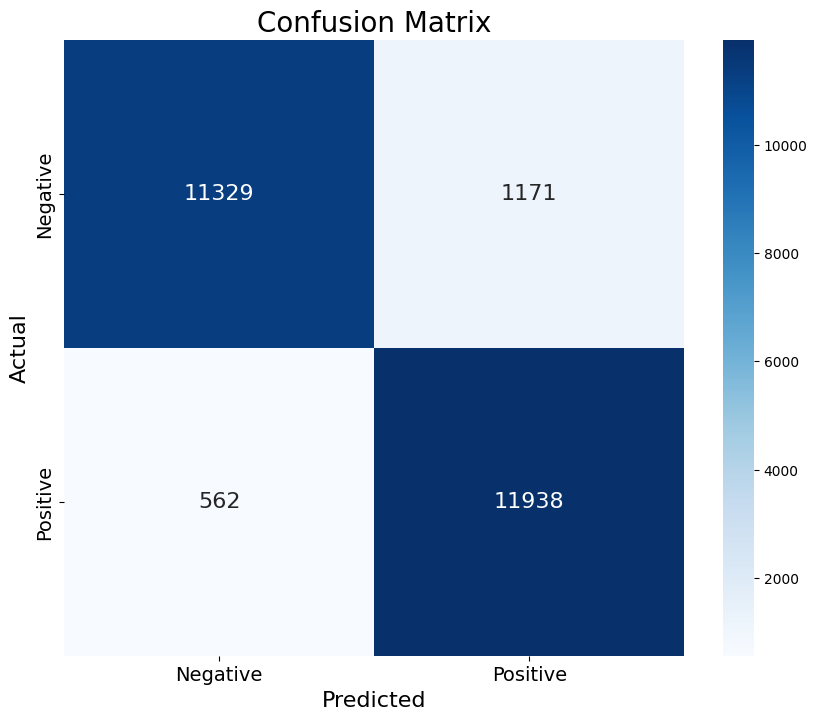

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = ['Negative','Positive']
test_df = test_data.to_pandas()
cm = confusion_matrix(test_df.label, predicted_label)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',
            xticklabels=class_names,yticklabels=class_names,
            annot_kws={'fontsize': 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted',fontsize=16)
plt.ylabel('Actual',fontsize=16)
plt.title("Confusion Matrix",fontsize=20)
plt.show()

In [ ]:
print(classification_report(test_df.label, predicted_label,target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.95      0.91      0.93     12500
    Positive       0.91      0.96      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



模型在其他指標上也同樣都有90%以上的準確度，再次證明該模型的確具有良好的預測能力。

# 預測電影評論

建立了幾個電影評論，觀察模型面對新評論的預測結果。

In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, round(predicted_probability,4)

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.9787)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.986)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.993)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.9883)

可看到模型對新資料具有良好表現。為了測試模型能否處理較長的評論，因此我輸入我對最近一部電影（鬼滅之刃無限城）的評論英文版。

In [ ]:
text = "The movie's visuals and fight choreography were exquisite and fluid. However, because it's an adaptation of a manga and the production team didn't alter the story's pacing, the weekly-release rhythm of the original manga doesn't entirely suit a movie format, which is a bit of a shame."

predict_sentiment(text, model, tokenizer, device)

(1, 0.7547)

模型的確判別出了我內心的情緒。

IMDB 電影評論情緒分析就到這裡，謝謝大家。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 假設你的模型是 model
torch.save(model.state_dict(), '/content/drive/My Drive/my_model.pth')

Mounted at /content/drive


In [97]:
from google.colab import drive
drive.mount('/content/drive')

# 建立模型實例
model = Transformer(transformer, output_dim, freeze)
# 載入儲存的狀態
model.load_state_dict(torch.load('/content/drive/My Drive/my_model.pth'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>